In [66]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [67]:
# --- Data Loading ---
def load_yield_data(filepath, target_date, interpolate=False):
    """Load and process yield curve data for a specific date with optional interpolation."""
    try:
        df = pd.read_csv(filepath)
        data_on_date = df[df['Date'] == target_date].copy()
        if data_on_date.empty:
            raise ValueError(f"No data found for date {target_date}")
        
        target_date = pd.to_datetime(target_date)
        all_maturities = sorted(set(col.split('_')[1] for col in df.columns if 'Time_' in col))
        
        maturities = []
        for mat in all_maturities:
            try:
                mat_date = pd.to_datetime(mat, format='%b%Y')
                if mat_date > target_date:
                    maturities.append(mat)
            except ValueError:
                continue
        
        if not maturities:
            raise ValueError(f"No valid maturities found for date {target_date}")
        
        for mat in maturities:
            time_col = f'Time_{mat}'
            yield_col = f'Yield_{mat}'
            if time_col in data_on_date.columns:
                data_on_date[time_col] = pd.to_numeric(data_on_date[time_col], errors='coerce')
            if yield_col in data_on_date.columns:
                data_on_date[yield_col] = pd.to_numeric(data_on_date[yield_col], errors='coerce')
        
        valid_cols = [f'Time_{mat}' for mat in maturities if f'Time_{mat}' in data_on_date.columns] + \
                     [f'Yield_{mat}' for mat in maturities if f'Yield_{mat}' in data_on_date.columns]
        data_on_date = data_on_date.dropna(subset=valid_cols)
        
        if data_on_date.empty:
            raise ValueError(f"No valid data after dropping NaN for date {target_date}")
        
        times = np.array([data_on_date[f'Time_{mat}'].values[0] for mat in maturities])
        yields = np.array([data_on_date[f'Yield_{mat}'].values[0] for mat in maturities]) * 100
        valid_idx = ~np.isnan(times) & ~np.isnan(yields)
        times, yields = times[valid_idx], yields[valid_idx]
        
        if interpolate:
            standard_times = np.linspace(0.25, 5.0, 20)
            if len(times) > 1:
                interp_yields = np.interp(standard_times, times, yields, left=np.nan, right=np.nan)
                valid_interp = ~np.isnan(interp_yields)
                times = standard_times[valid_interp]
                yields = interp_yields[valid_interp]
            else:
                raise ValueError(f"Insufficient valid data points for interpolation on {target_date}")
        
        return times, yields
    except Exception as e:
        raise Exception(f"Error loading data for {target_date}: {str(e)}")

In [68]:

# --- Two-Factor Hull-White Model ---
class Two_Factor_Hull_White:
    def __init__(self, x1_0, x2_0, kappa1, kappa2, sigma1, sigma2, theta, lambda_, rho):
        self.x1_0 = x1_0
        self.x2_0 = x2_0
        self.kappa1 = kappa1
        self.kappa2 = kappa2
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.theta = theta
        self.lambda_ = lambda_
        self.rho = rho
    
    def update_params(self, params):
        self.x1_0, self.x2_0, self.kappa1, self.kappa2, self.sigma1, self.sigma2, self.theta, self.lambda_, self.rho = params
    
    def simulate_paths(self, T, dt, n_paths):
        steps = int(T / dt)
        x1 = np.zeros((n_paths, steps + 1))
        x2 = np.zeros((n_paths, steps + 1))
        x1[:, 0] = self.x1_0
        x2[:, 0] = self.x2_0
        
        cov_matrix = [[dt, self.rho * dt], [self.rho * dt, dt]]
        dW = np.random.multivariate_normal([0, 0], cov_matrix, (n_paths, steps))
        dW1, dW2 = dW[:, :, 0], dW[:, :, 1]
        
        for t in range(steps):
            time = t * dt
            # Simplified mean reversion to avoid numerical issues
            mean_reversion1 = self.kappa1 * (self.theta - x1[:, t])
            mean_reversion2 = self.kappa2 * (self.theta - x2[:, t])
            x1[:, t + 1] = x1[:, t] + mean_reversion1 * dt + self.sigma1 * np.sqrt(dt) * dW1[:, t]
            x2[:, t + 1] = x2[:, t] + mean_reversion2 * dt + self.sigma2 * np.sqrt(dt) * dW2[:, t]
        
        r = x1 + x2 + self.lambda_
        return np.linspace(0, T, steps + 1), r
    
    def yield_curve(self, T, r0):
        B1 = (1 - np.exp(-self.kappa1 * T)) / max(abs(self.kappa1), 1e-4) if abs(self.kappa1) > 1e-4 else T
        B2 = (1 - np.exp(-self.kappa2 * T)) / max(abs(self.kappa2), 1e-4) if abs(self.kappa2) > 1e-4 else T
        A = self.compute_A(T)
        # Simplified yield curve to stabilize output
        return (A + B1 * self.x1_0 + B2 * self.x2_0 + self.lambda_) / T
    
    def compute_A(self, T):
        epsilon = 1e-3  # Increased from 1e-4
        kappa1_safe = max(abs(self.kappa1), epsilon)
        kappa2_safe = max(abs(self.kappa2), epsilon)
        term1 = self.sigma1**2 / (2 * kappa1_safe**2) * (T + 2 / kappa1_safe * np.exp(-kappa1_safe * T) - 1 / (2 * kappa1_safe) * np.exp(-2 * kappa1_safe * T) - 3 / (2 * kappa1_safe)) if abs(self.kappa1) > epsilon else self.sigma1**2 * T**3 / 6
        term2 = self.sigma2**2 / (2 * kappa2_safe**2) * (T + 2 / kappa2_safe * np.exp(-kappa2_safe * T) - 1 / (2 * kappa2_safe) * np.exp(-2 * kappa2_safe * T) - 3 / (2 * kappa2_safe)) if abs(self.kappa2) > epsilon else self.sigma2**2 * T**3 / 6
        term3 = self.rho * self.sigma1 * self.sigma2 / (kappa1_safe * kappa2_safe) * (T + (np.exp(-kappa1_safe * T) - 1) / kappa1_safe + (np.exp(-kappa2_safe * T) - 1) / kappa2_safe - (np.exp(-(kappa1_safe + kappa2_safe) * T) - 1) / (kappa1_safe + kappa2_safe)) if abs(self.kappa1) > epsilon and abs(self.kappa2) > epsilon else self.rho * self.sigma1 * self.sigma2 * T**3 / 3
        return term1 + term2 + term3

In [69]:

# --- Fitter Class ---
class Fitter:
    def __init__(self, model, obs_yields, obs_times, dist='Q'):
        self.model = model
        self.data = np.array(obs_yields)
        self.times = np.array(obs_times)
        self.dist = dist
        self.model_yields = None
    
    def residuals(self, x):
        self.model.update_params(x)
        r0 = self.model.x1_0 + self.model.x2_0
        model_yields = np.array([self.model.yield_curve(t, r0) for t in self.times])
        residuals = model_yields - self.data
        weights = 1 / (1 + self.times)
        weights[:3] *= 2
        return residuals * weights
    
    def r_squared(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        y_mean = np.mean(self.data)
        ss_tot = np.sum((self.data - y_mean) ** 2)
        ss_res = np.sum((self.data - self.model_yields) ** 2)
        return 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    
    def rmse(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        return np.sqrt(np.mean((self.data - self.model_yields) ** 2))
    
    def fit(self, x0, solver='trf', bounds=None):
        bounds_for_least_squares = bounds if bounds else (
            [0.0, 0.0, -0.5, -0.5, 0.0001, 0.0001, 0.0, 0.0, -0.99],
            [0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 1.0, 0.5, 0.99]
        )
        result = least_squares(self.residuals, x0, method=solver, bounds=bounds_for_least_squares, ftol=1e-12, xtol=1e-12)
        self.model.update_params(result.x)
        self.model_yields = np.array([self.model.yield_curve(t, self.model.x1_0 + self.model.x2_0) for t in self.times])
        return result

In [70]:

# --- Forecasting and Optimization ---
def forecast_and_optimize(model, times, initial_params, bounds, forecast_date, actual_yields, dt=1/252, n_paths=5000):
    """Forecast yields with relaxed bounds and reduced penalties."""
    forecast_days = (pd.to_datetime(forecast_date) - pd.to_datetime('2025-01-31')).days
    T = forecast_days / 365.0
    
    def objective(params):
        model.update_params(params)
        _, r_paths = model.simulate_paths(T, dt, n_paths)
        r_forecast = r_paths[:, -1]
        forecast_yields = np.array([np.mean([model.yield_curve(t, r) for r in r_forecast]) for t in times])
        
        residuals = forecast_yields - actual_yields / 100
        weights = 1 / (1 + times)
        weights[:3] *= 2
        weighted_residuals = residuals * weights
        
        slope_forecast = (forecast_yields[-1] - forecast_yields[0]) / (times[-1] - times[0])
        slope_actual = (actual_yields[-1] - actual_yields[0]) / (times[-1] - times[0])
        slope_penalty = 50 * (slope_forecast - slope_actual) ** 2
        
        curvature_forecast = np.diff(np.diff(forecast_yields)).mean() if len(forecast_yields) > 2 else 0
        curvature_actual = np.diff(np.diff(actual_yields / 100)).mean() if len(actual_yields) > 2 else 0
        curvature_penalty = 25 * (curvature_forecast - curvature_actual) ** 2
        
        param_penalty = 0.01 * np.sum((params - initial_params) ** 2)
        
        total_error = np.sum(weighted_residuals ** 2) + slope_penalty + curvature_penalty + param_penalty
        return np.append(weighted_residuals, np.sqrt([slope_penalty, curvature_penalty, param_penalty]))
    
    # Relaxed tightened bounds
    epsilon = 1e-6
    tightened_bounds = (
        [max(bounds[0][i], min(initial_params[i] - 0.5 * abs(initial_params[i]), initial_params[i])) for i in range(len(initial_params))],
        [min(bounds[1][i], max(initial_params[i] + 0.5 * abs(initial_params[i]), initial_params[i]) + epsilon) for i in range(len(initial_params))]
    )
    tightened_bounds = (
        [min(tightened_bounds[0][i], initial_params[i] - epsilon) for i in range(len(initial_params))],
        [max(tightened_bounds[1][i], initial_params[i] + epsilon) for i in range(len(initial_params))]
    )
    
    print("Initial Params:", initial_params)
    print("Tightened Bounds Lower:", tightened_bounds[0])
    print("Tightened Bounds Upper:", tightened_bounds[1])
    
    result = least_squares(objective, initial_params, bounds=tightened_bounds, method='trf')
    model.update_params(result.x)
    
    _, r_paths = model.simulate_paths(T, dt, n_paths)
    r_forecast = r_paths[:, -1]
    forecast_yields = np.array([np.mean([model.yield_curve(t, r) for r in r_forecast]) for t in times])
    forecast_std = np.array([np.std([model.yield_curve(t, r) for r in r_forecast]) for t in times])
    
    print(f"Forecasted Yields for {forecast_date}:", forecast_yields * 100)
    
    return {
        'mean': forecast_yields * 100,
        'lower': (forecast_yields - 1.96 * forecast_std) * 100,
        'upper': (forecast_yields + 1.96 * forecast_std) * 100,
        'confidence': 0.95,
        'params': result.x
    }

In [71]:

def forecast_yields(model, times, forecast_date, dt=1/252, n_paths=1000):
    """Forecast yields for a future date without optimization."""
    forecast_days = (pd.to_datetime(forecast_date) - pd.to_datetime('2025-01-31')).days
    T = forecast_days / 365.0
    
    _, r_paths = model.simulate_paths(T, dt, n_paths)
    r_forecast = r_paths[:, -1]
    forecast_yields = np.array([np.mean([model.yield_curve(t, r) for r in r_forecast]) for t in times])
    forecast_std = np.array([np.std([model.yield_curve(t, r) for r in r_forecast]) for t in times])
    
    return {
        'mean': forecast_yields * 100,
        'lower': (forecast_yields - 1.96 * forecast_std) * 100,
        'upper': (forecast_yields + 1.96 * forecast_std) * 100,
        'confidence': 0.95
    }


In [72]:

# --- Metrics Calculation ---
def calculate_metrics(actual, predicted):
    """Calculate RMSE and R^2 metrics."""
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    y_mean = np.mean(actual)
    ss_tot = np.sum((actual - y_mean) ** 2)
    ss_res = np.sum((actual - predicted) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    return rmse, r2

In [73]:

# --- Plotting ---
def plot_yield_comparison(times, yields=None, fitted=None, forecast=None, historical=None,
                          metrics_text=None, title=None, figsize=(12, 8), dpi=100):
    plt.figure(figsize=figsize, dpi=dpi)
    sorted_idx = np.argsort(times)
    times_sorted = times[sorted_idx]
    
    if yields is not None:
        plt.plot(times_sorted, yields[sorted_idx], 'o-', label='Observed Yields', color='#1f77b4', linewidth=2)
    if fitted is not None:
        plt.plot(times_sorted, fitted[sorted_idx], 's--', label='Fitted Yields', color='#d62728', linewidth=2)
    if forecast is not None:
        fcst_mean = forecast['mean'][sorted_idx]
        plt.plot(times_sorted, fcst_mean, 'D-', label='Forecasted Yields', color='#2ca02c', linewidth=2)
        if 'lower' in forecast and 'upper' in forecast:
            plt.fill_between(times_sorted, forecast['lower'][sorted_idx], forecast['upper'][sorted_idx],
                            color='#2ca02c', alpha=0.15, label=f"{forecast['confidence']*100}% Confidence Band")
    if historical is not None:
        for series in historical:
            hist_times = series['times'][np.argsort(series['times'])]
            hist_yields = series['yields'][np.argsort(series['times'])]
            plt.plot(hist_times, hist_yields, series.get('marker', 'o'), label=series.get('label'), 
                     color=series.get('color', '#7f7f7f'), markersize=8, linestyle='none')
    
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Yield (%)')
    plt.title(title or 'Yield Curve Comparison')
    plt.legend(loc='best')
    if metrics_text:
        plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, fontsize=10, 
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.grid(True)
    plt.show()


In [74]:
# --- Main Execution ---
# Main Execution
filepath = '/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv'
dates = ['2025-01-31', '2025-02-04', '2025-03-04', '2025-04-04']
data = {date: load_yield_data(filepath, date, interpolate=False) for date in dates}
times_jan31, yields_jan31 = data['2025-01-31']
times_feb04, yields_feb04 = data['2025-02-04']
times_mar04, yields_mar04 = data['2025-03-04']
times_apr04, yields_apr04 = data['2025-04-04']

# Updated bounds and initial guess
x0 = [0.015, 0.015, 0.05, 0.05, 0.005, 0.005, 0.3, 0.05, 0.3]
bounds = (
    [0.005, 0.005, 0.001, 0.001, 0.0005, 0.0005, 0.05, 0.001, -0.99],
    [0.08, 0.08, 1.0, 1.0, 0.02, 0.02, 2.0, 1.0, 0.99]
)

Jan 31 Fit Metrics:
$R^2$: -10.20
RMSE: 0.69%
Jan 31 Times: [ 0.53661875  1.53593429  2.53524983  3.53730322  4.53661875  5.53593429
  6.53524983  7.53730322  8.53661875  9.53593429 14.53524983  0.04106776
  1.0403833   2.03969884  3.03901437  4.04106776  6.03969884  7.03901437
  8.04106776  9.0403833  11.03901437 12.04106776 13.0403833  14.03969884
  0.28473648  1.28405202  2.28336756  3.28542094  4.28473648  5.28405202
  6.28336756  7.28542094  8.28473648  9.28405202 12.28473648 13.28405202
 14.28336756  0.78850103  1.78781656  2.7871321   3.78918549  5.78781656
  6.7871321   7.78918549  8.78850103  9.78781656]
Jan 31 Yields: [3.694 4.066 4.158 4.157 4.294 4.368 4.425 4.457 4.493 4.525 4.701 4.159
 4.1   3.948 4.246 4.176 4.379 4.444 4.477 4.515 4.402 4.489 4.589 4.639
 4.221 4.208 4.214 4.258 4.304 4.332 4.409 4.447 4.487 4.517 4.524 4.582
 4.688 4.22  3.867 4.172 4.278 4.363 4.44  4.442 4.493 4.531]
Jan 31 Fitted Yields: [3.65883561 3.56419684 3.59252238 3.66291613 3.76532567 3.897

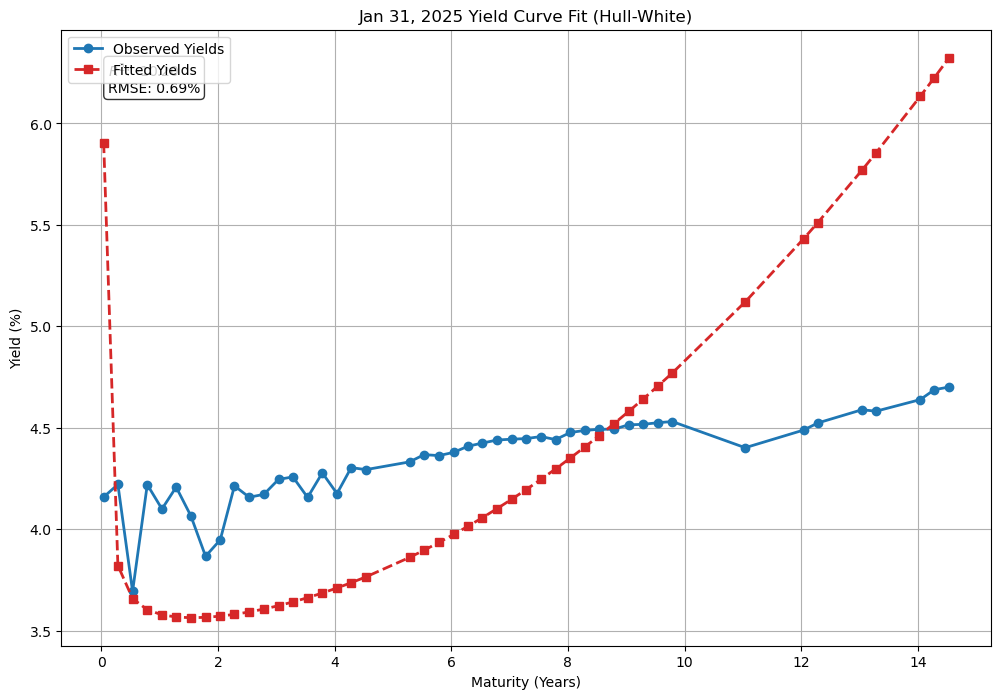

In [75]:
# Fit Jan 31
model = Two_Factor_Hull_White(*x0)
fitter = Fitter(model, yields_jan31 / 100, times_jan31)
fit_result = fitter.fit(x0, solver='trf', bounds=bounds)
fitted_yields = np.array([model.yield_curve(t, model.x1_0 + model.x2_0) for t in times_jan31]) * 100
r2_jan31 = fitter.r_squared()
rmse_jan31 = fitter.rmse() * 100
print(f"Jan 31 Fit Metrics:\n$R^2$: {r2_jan31:.2f}\nRMSE: {rmse_jan31:.2f}%")
print("Jan 31 Times:", times_jan31)
print("Jan 31 Yields:", yields_jan31)
print("Jan 31 Fitted Yields:", fitted_yields)
print("Jan 31 Optimized Params:", fit_result.x)
metrics_text_jan31 = f'$R^2$: {r2_jan31:.2f}\nRMSE: {rmse_jan31:.2f}%'

# Plot Jan 31 fit
plot_yield_comparison(
    times=times_jan31,
    yields=yields_jan31,
    fitted=fitted_yields,
    metrics_text=metrics_text_jan31,
    title='Jan 31, 2025 Yield Curve Fit (Hull-White)'
)

Initial Params: [5.00396781e-03 2.96912171e-02 1.00003520e-03 1.08086626e-03
 1.75922385e-02 1.44157594e-02 1.31964464e+00 1.00000000e-03
 6.07644904e-01]
Tightened Bounds Lower: [0.005, 0.014845608557619619, 0.000999035199101793, 0.001, 0.008796119252529468, 0.0072078797024761046, 0.6598223206927211, 0.0009990000000000003, 0.30382245213519643]
Tightened Bounds Upper: [0.0075069517111386605, 0.044537825672858855, 0.001501052798652689, 0.0016222993922582636, 0.02, 0.02, 1.9794679620781632, 0.0015010000000000004, 0.9114683564055893]
Forecasted Yields for 2025-02-04: [3.86830504 3.79414711 3.86944914 4.01075387 4.20750039 4.45727872
 4.7590194  5.11324348 5.51772648 5.97318648 9.01376613 3.79434166
 3.82255924 3.93317089 4.10320038 4.60293421 4.93065517 5.31076611
 5.74096518 6.75398958 7.33829766 7.97174168 8.65579473 4.03847646
 3.78961502 3.84352654 3.96977996 4.15284701 4.38939432 4.6780999
 5.01935486 5.41096361 5.85358784 7.48808546 8.13387443 8.8302604
 3.81464365 3.8055849  3.8993

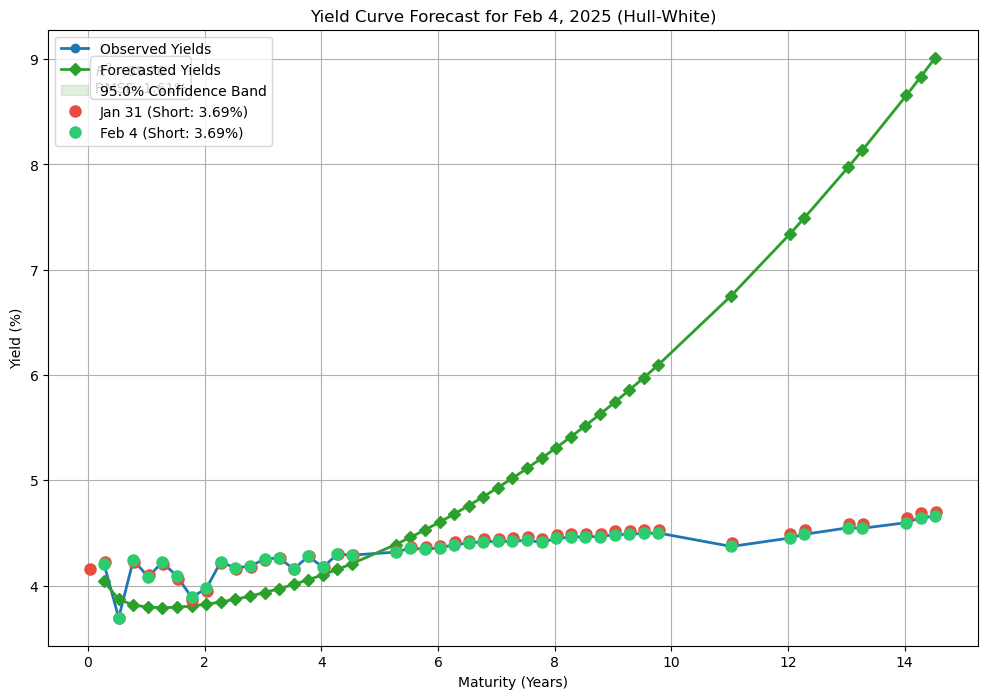

In [76]:
# Forecast and optimize for Feb 4
feb04_forecast = forecast_and_optimize(model, times_feb04, fit_result.x, bounds, '2025-02-04', yields_feb04, n_paths=5000)
rmse_feb04, r2_feb04 = calculate_metrics(yields_feb04, feb04_forecast['mean'])
print(f"Feb 4 Forecast Metrics:\n$R^2$: {r2_feb04:.2f}\nRMSE: {rmse_feb04:.2f}%")
print("Feb 4 Forecasted Yields:", feb04_forecast['mean'])
print("Feb 4 Actual Yields:", yields_feb04)
metrics_text_feb04 = f'$R^2$: {r2_feb04:.2f}\nRMSE: {rmse_feb04:.2f}%'

# Plot Feb 4 forecast
plot_yield_comparison(
    times=times_feb04,
    yields=yields_feb04,
    forecast=feb04_forecast,
    historical=[
        {'times': times_jan31, 'yields': yields_jan31, 'label': f'Jan 31 (Short: {yields_jan31[0]:.2f}%)', 'color': '#e74c3c', 'marker': 'o'},
        {'times': times_feb04, 'yields': yields_feb04, 'label': f'Feb 4 (Short: {yields_feb04[0]:.2f}%)', 'color': '#2ecc71', 'marker': 'o'}
    ],
    metrics_text=metrics_text_feb04,
    title='Yield Curve Forecast for Feb 4, 2025 (Hull-White)'
)

In [77]:
# Forecast and optimize for Mar 4
mar04_forecast = forecast_and_optimize(model, times_mar04, feb04_forecast['params'], bounds, '2025-03-04', yields_mar04, n_paths=5000)
rmse_mar04, r2_mar04 = calculate_metrics(yields_mar04, mar04_forecast['mean'])
print(f"Mar 4 Forecast Metrics:\n$R^2$: {r2_mar04:.2f}\nRMSE: {rmse_mar04:.2f}%")
print("Mar 4 Forecasted Yields:", mar04_forecast['mean'])
print("Mar 4 Actual Yields:", yields_mar04)
metrics_text_mar04 = f'$R^2$: {r2_mar04:.2f}\nRMSE: {rmse_mar04:.2f}%'

# Plot Mar 4 forecast
plot_yield_comparison(
    times=times_mar04,
    yields=yields_mar04,
    forecast=mar04_forecast,
    historical=[
        {'times': times_jan31, 'yields': yields_jan31, 'label': f'Jan 31 (Short: {yields_jan31[0]:.2f}%)', 'color': '#e74c3c', 'marker': 'o'},
        {'times': times_feb04, 'yields': yields_feb04, 'label': f'Feb 4 (Short: {yields_feb04[0]:.2f}%)', 'color': '#2ecc71', 'marker': 'o'},
        {'times': times_mar04, 'yields': yields_mar04, 'label': f'Mar 4 (Short: {yields_mar04[0]:.2f}%)', 'color': '#000000', 'marker': 'o'}
    ],
    metrics_text=metrics_text_mar04,
    title='Yield Curve Forecast for Mar 4, 2025 (Hull-White)'
)

Initial Params: [5.46470057e-03 3.12571392e-02 9.99035199e-04 1.00000000e-03
 2.00000000e-02 2.00000000e-02 1.31930881e+00 9.99000000e-04
 9.11468044e-01]
Tightened Bounds Lower: [0.005, 0.015628569577080295, 0.0009980351991017932, 0.0009990000000000003, 0.009999999999999998, 0.009999999999999998, 0.6596544050858663, 0.0009980000000000006, 0.4557340220371939]
Tightened Bounds Upper: [0.008198050857669321, 0.046886708731240886, 0.0014995527986526897, 0.0015010000000000004, 0.020000999999999998, 0.020000999999999998, 1.9789642152575986, 0.0014995000000000006, 0.99]


KeyboardInterrupt: 

In [ ]:
# Forecast for Apr 4 (no optimization, using forecast_yields)
apr04_forecast = forecast_yields(model, times_apr04, '2025-04-04', dt=1/252, n_paths=5000)
rmse_apr04, r2_apr04 = calculate_metrics(yields_apr04, apr04_forecast['mean'])
print(f"Apr 4 Forecast Metrics:\n$R^2$: {r2_apr04:.2f}\nRMSE: {rmse_apr04:.2f}%")
print("Apr 4 Forecasted Yields:", apr04_forecast['mean'])
print("Apr 4 Actual Yields:", yields_apr04)
metrics_text_apr04 = f'$R^2$: {r2_apr04:.2f}\nRMSE: {rmse_apr04:.2f}%'

# Plot Apr 4 forecast
plot_yield_comparison(
    times=times_apr04,
    yields=yields_apr04,
    forecast=apr04_forecast,
    historical=[
        {'times': times_jan31, 'yields': yields_jan31, 'label': f'Jan 31 (Short: {yields_jan31[0]:.2f}%)', 'color': '#e74c3c', 'marker': 'o'},
        {'times': times_feb04, 'yields': yields_feb04, 'label': f'Feb 4 (Short: {yields_feb04[0]:.2f}%)', 'color': '#2ecc71', 'marker': 'o'},
        {'times': times_mar04, 'yields': yields_mar04, 'label': f'Mar 4 (Short: {yields_mar04[0]:.2f}%)', 'color': '#000000', 'marker': 'o'},
        {'times': times_apr04, 'yields': yields_apr04, 'label': f'Apr 4 (Short: {yields_apr04[0]:.2f}%)', 'color': '#9b59b6', 'marker': 'o'}
    ],
    metrics_text=metrics_text_apr04,
    title='Yield Curve Forecast for April 4, 2025'
)

In [ ]:
# Print diagnostics
print("Jan 31 Params:", fit_result.x)
print("Feb 4 Params:", feb04_forecast['params'])
print("Mar 4 Params:", mar04_forecast['params'])
print("Apr 4 Params:", apr04_forecast.get('params', 'No params available'))
print("Mar 4 Times:", times_mar04)
print("Mar 4 Yields:", yields_mar04)
print("Apr 4 Times:", times_apr04)
print("Apr 4 Yields:", yields_apr04)